In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import random
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader


In [2]:
# Set the random seed for reproducibility
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# Generate 20000 samples of the sum of rolling two six-sided dice

def rolling_dice(n_samples: int) -> np.array:
    dice_1 = np.random.randint(1, 7, n_samples)
    dice_2 = np.random.randint(1, 7, n_samples)
    dice_sum = dice_1 + dice_2

    return dice_sum

n_samples = 50000
dice_sum = rolling_dice(n_samples)

In [4]:
def calculate_probabilities(samples, batch_size):
        # Initialize an array to hold counts of each possible result (0 to 15)
        probs = []
        
        for i in range(int(len(samples)/batch_size)):
            counts = np.zeros(16)
            data = samples[i*batch_size:(i+1)*batch_size]
            # Count the occurrences of each result
            for value in data:
                counts[int(value)] += 1
            
            # Calculate probabilities by normalizing the counts
            probabilities = counts / len(data)
            probs.append(probabilities)
        
        return np.array(probs)

probs = calculate_probabilities(dice_sum, 5000)

<BarContainer object of 16 artists>

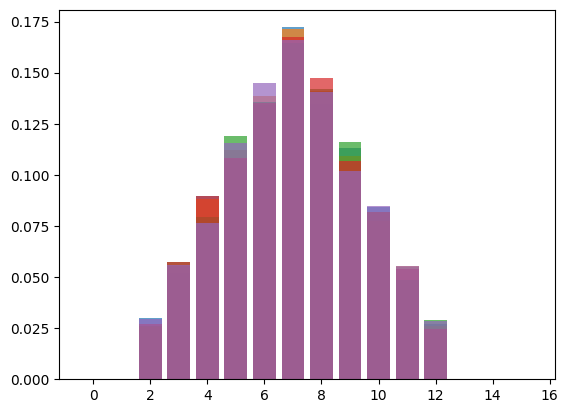

In [5]:
x = list(range(16)) 
plt.bar(x, probs[0], alpha=0.7, label="real distribution")
plt.bar(x, probs[1], alpha=0.7, label="real distribution")
plt.bar(x, probs[2], alpha=0.7, label="real distribution")
plt.bar(x, probs[3], alpha=0.7, label="real distribution")
plt.bar(x, probs[4], alpha=0.7, label="real distribution")

In [6]:
class DiceDataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [7]:
# Create the data loader instance
dataset = DiceDataset(probs)
dataloader = DataLoader(dataset, batch_size=1)

In [8]:
n_qubits = 5
n_a_qubits = 1
q_depth = 6 

In [9]:
# Discriminator implementation

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(16, 50),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(50, 20),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        
        return self.model(x)


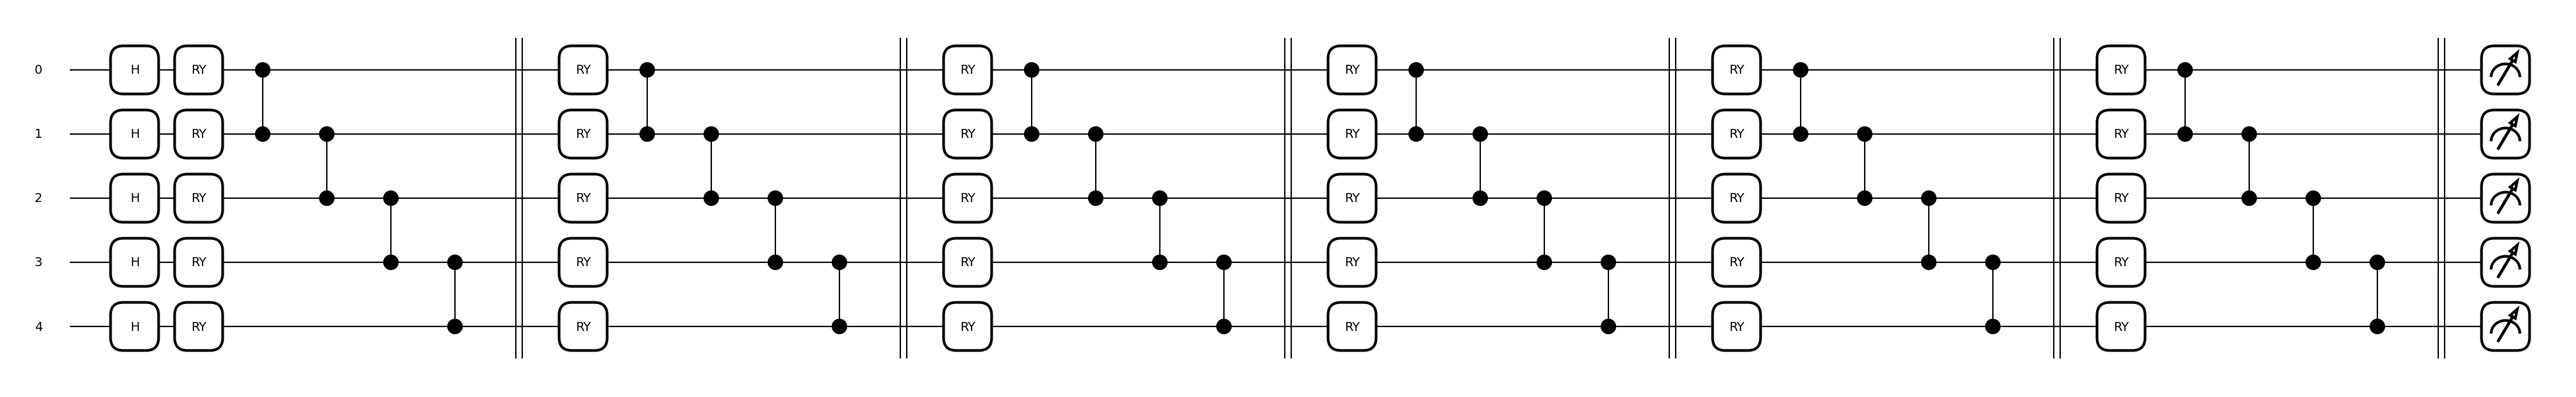

In [10]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))

noise = torch.rand(1, n_qubits, device=device) 
weights = torch.rand(1, n_qubits*q_depth) 

qml.draw_mpl(quantum_circuit)(weights=weights)
plt.show()

In [11]:
def partial_measure(weights):
    # Non-linear Transform
    probs = quantum_circuit(weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    return probsgiven0

In [12]:
class QuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.rand(q_depth * n_qubits), requires_grad=True)
            ]
        )

    def forward(self):

        qc_out = partial_measure(self.q_params[0]).float().unsqueeze(0)
        
        return qc_out
        

In [13]:
discriminator = Discriminator().to(device)
generator = QuantumGenerator().to(device)

In [14]:
for param in generator.parameters():
    print(param)

Parameter containing:
tensor([0.9530, 0.0023, 0.7123, 0.0629, 0.9684, 0.3823, 0.5410, 0.2648, 0.0854,
        0.6262, 0.8289, 0.6395, 0.4495, 0.0787, 0.6103, 0.8224, 0.7922, 0.9845,
        0.0397, 0.9252, 0.4681, 0.0870, 0.8559, 0.8433, 0.5195, 0.7860, 0.0555,
        0.1266, 0.7983, 0.8123], requires_grad=True)


In [15]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [16]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []

In [17]:
for i, data in enumerate(dataloader):
    #data = data.reshape(-1, data.size(0))
    real_data = data.to(device)

    #noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
    fake_data = generator()

    discriminator.zero_grad()
    outD_real = discriminator(real_data).view(-1)
    outD_fake = discriminator(fake_data.detach()).view(-1)

In [18]:
while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
        fake_data = generator()

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())

    counter += 1
    if counter == num_iter:
        break


Iteration: 0, Discriminator Loss: 1.392, Generator Loss: 0.769
Iteration: 10, Discriminator Loss: 1.385, Generator Loss: 0.732
Iteration: 20, Discriminator Loss: 1.381, Generator Loss: 0.715
Iteration: 30, Discriminator Loss: 1.379, Generator Loss: 0.706
Iteration: 40, Discriminator Loss: 1.385, Generator Loss: 0.697
Iteration: 50, Discriminator Loss: 1.389, Generator Loss: 0.696
Iteration: 60, Discriminator Loss: 1.384, Generator Loss: 0.702
Iteration: 70, Discriminator Loss: 1.378, Generator Loss: 0.709
Iteration: 80, Discriminator Loss: 1.376, Generator Loss: 0.710
Iteration: 90, Discriminator Loss: 1.376, Generator Loss: 0.708
Iteration: 100, Discriminator Loss: 1.377, Generator Loss: 0.702
Iteration: 110, Discriminator Loss: 1.377, Generator Loss: 0.699
Iteration: 120, Discriminator Loss: 1.374, Generator Loss: 0.698
Iteration: 130, Discriminator Loss: 1.368, Generator Loss: 0.701
Iteration: 140, Discriminator Loss: 1.364, Generator Loss: 0.702
Iteration: 150, Discriminator Loss: 

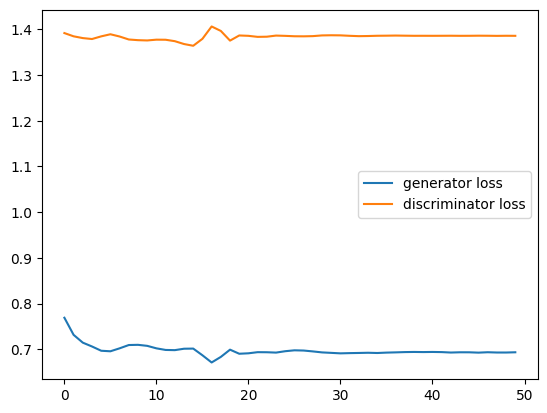

In [19]:
plt.plot(gen_loss, label="generator loss")
plt.plot(disc_loss, label="discriminator loss")
plt.legend()
plt.show()

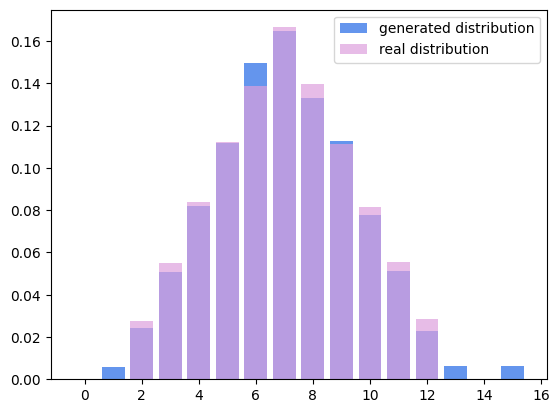

In [20]:
gen = generator().detach().numpy()
real = np.mean(probs, axis=0)
x = list(range(16)) 

plt.bar(x, gen[0], color="cornflowerblue", label="generated distribution")
plt.bar(x, real, color="plum", alpha=0.7, label="real distribution")
plt.legend()
plt.show()